# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [5]:
conditions = ['human', 'chimp', 'macaque', 'spatial_libd_human']
cond_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue']
color_dict = {'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'spatial_libd_human': 'tab:blue'}

# Load files

## Pseudobulks

### Load

In [6]:
dir_path = '../data/pseudobulks/'

In [7]:
os.listdir(dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [8]:
adata_pb_adult = sc.read_h5ad(dir_path + 'pb_age.h5ad')
adata_pb_adult

AnnData object with n_obs × n_vars = 111 × 17919
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [10]:
adata_pb_mamm = sc.read_h5ad(dir_path + 'pb_mammals.h5ad')
adata_pb_mamm

AnnData object with n_obs × n_vars = 94 × 14963
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

### Preprocess

In [11]:
adata_merged = an.concat([adata_pb_mamm, adata_pb_adult[adata_pb_adult.obs.condition != 'human']], merge='same')
adata_merged

AnnData object with n_obs × n_vars = 170 × 14611
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [12]:
adata_merged.write_h5ad("results/adults_mammals.h5ad")

In [13]:
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)

normalizing counts per cell
    finished (0:00:00)


computing PCA
    with n_comps=34
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


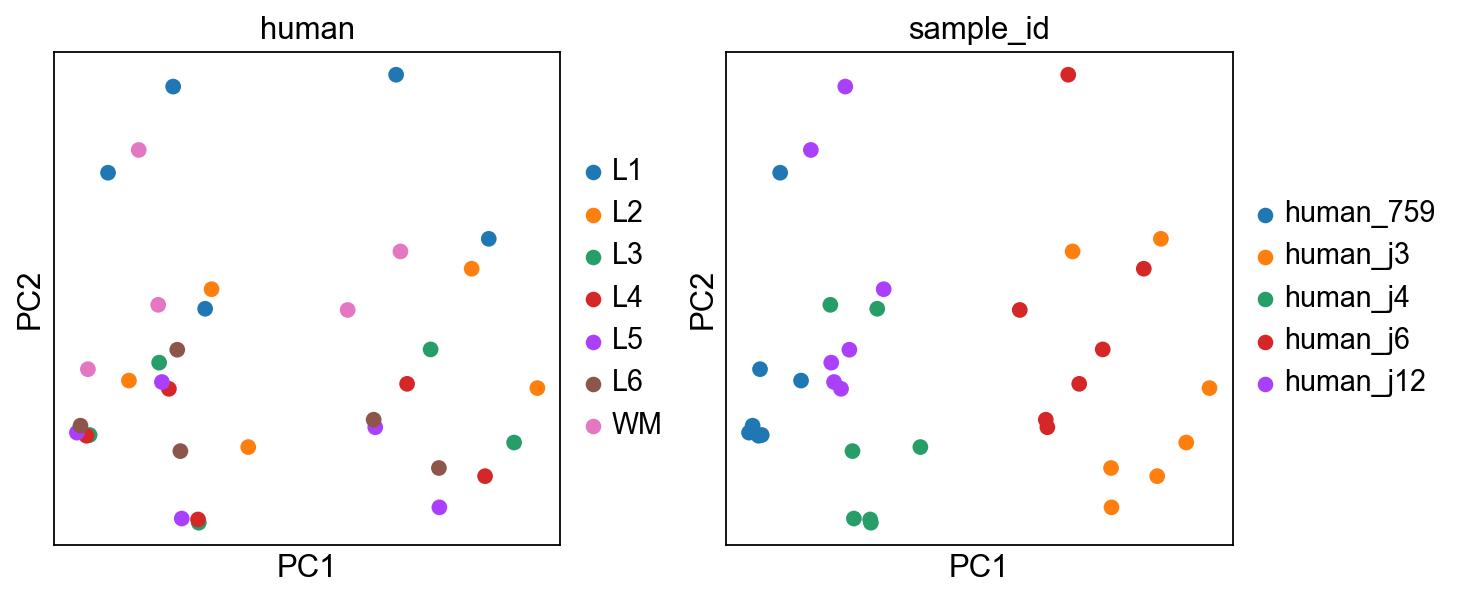

computing PCA
    with n_comps=30
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


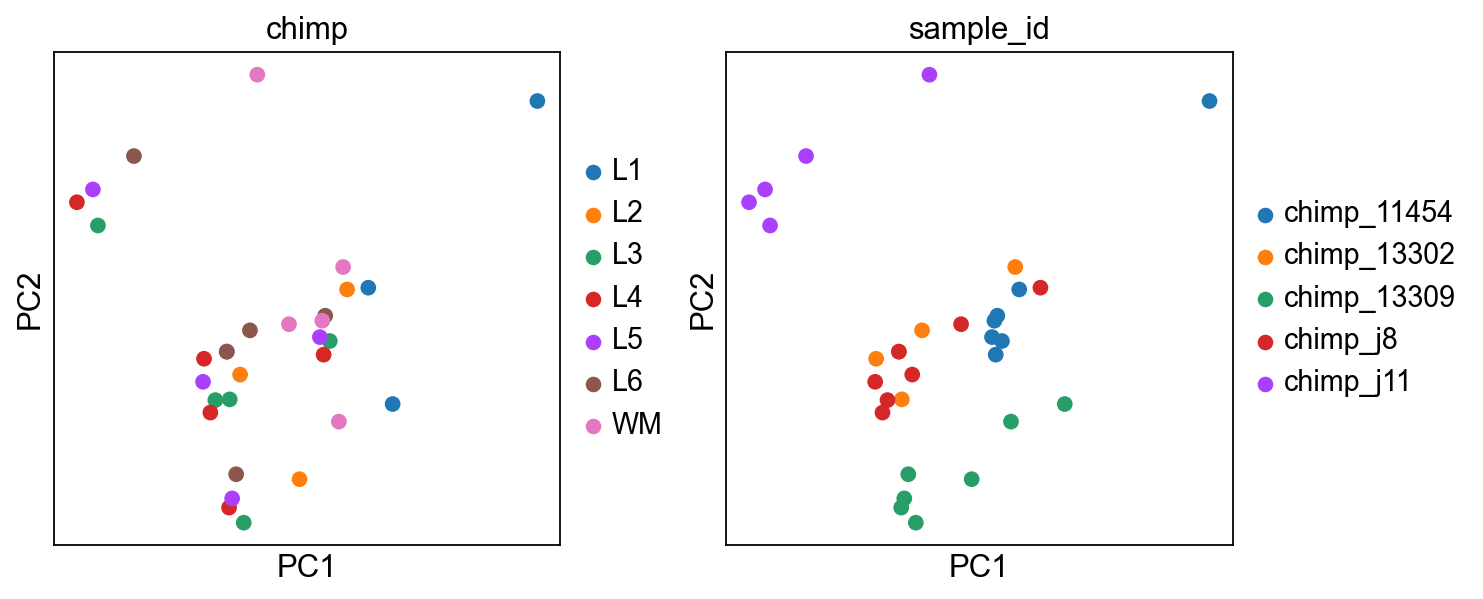

computing PCA
    with n_comps=27
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


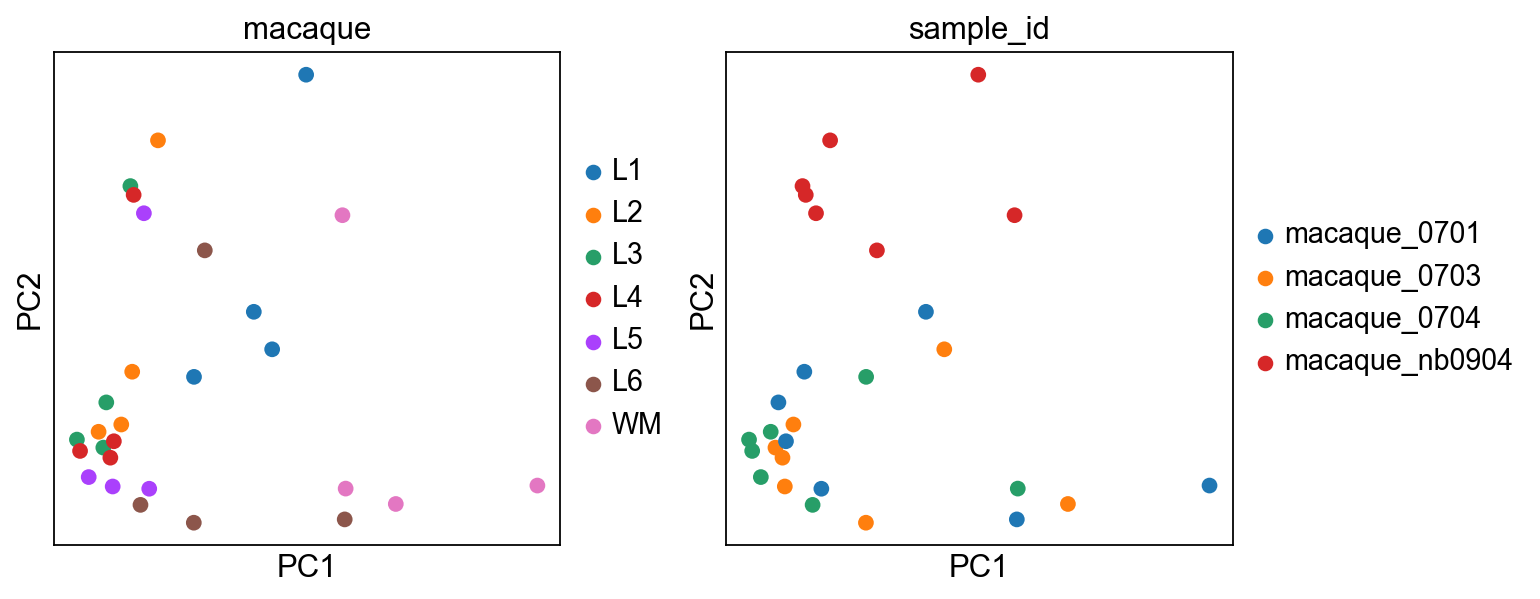

computing PCA
    with n_comps=50
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


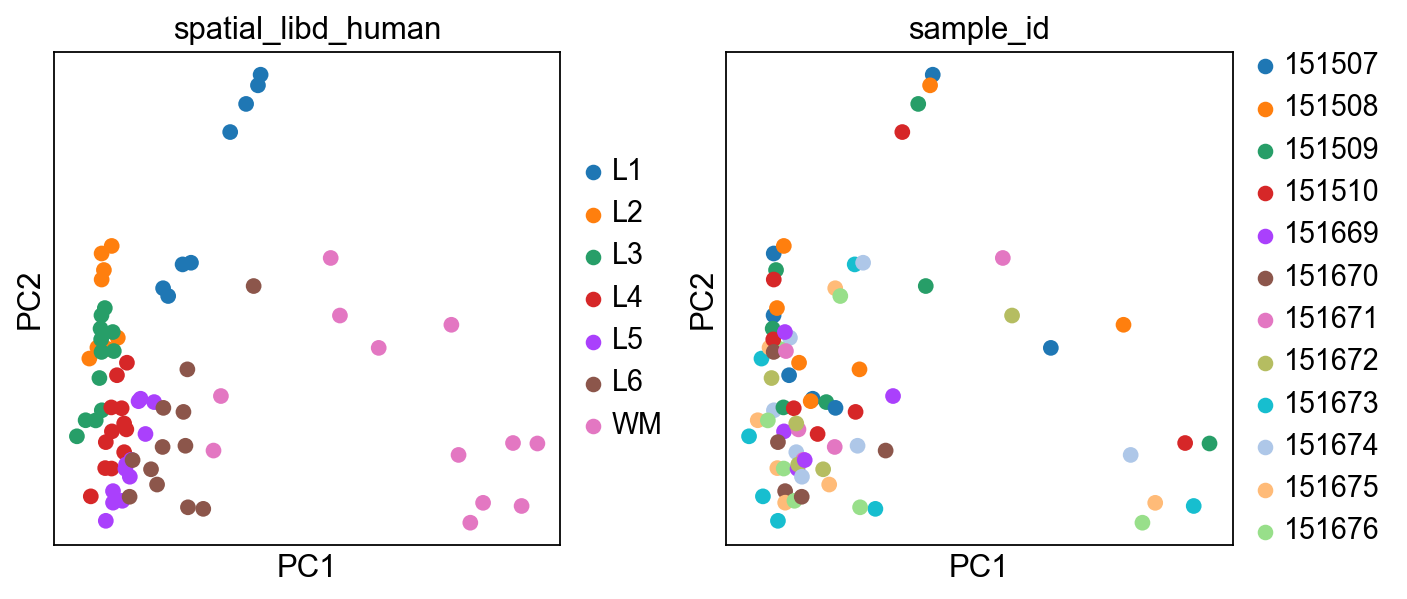

In [14]:
for cond in ['human', 'chimp', 'macaque', 'spatial_libd_human']:
    adata_cond = adata_merged[adata_merged.obs.condition == cond, :].copy()
    sc.pp.pca(adata_cond, return_info=False)
    sc.pl.pca(adata_cond, color=['layer', 'sample_id'], size=200, ncols=2, title=cond)

In [15]:
def subtract_mean(adata):
    # calculate mean gene expr for each sample
    gene_mean_list = []
    sample_layer_list = adata.obs.sample_id.unique().tolist()
    for sample in sample_layer_list:
        gene_mean_list.append(adata[adata.obs.sample_id == sample].X.mean(axis=0).reshape(-1, 1))
    # convert to DataFrame
    gene_mean_df = pd.DataFrame(np.concatenate(gene_mean_list, axis=1), columns=sample_layer_list, index=adata.var_names)
    gene_mean_df.head()
    
    # subtract mean and return adata
    for sample in sample_layer_list:
        columns = adata.obs[adata.obs.sample_id == sample].index.to_list()
        for column in columns:
            adata[column].X = adata[column].X - gene_mean_df.loc[:, sample].values
    return adata

In [16]:
adata_pb_merged_norm = subtract_mean(adata_merged)
adata_pb_merged_norm

AnnData object with n_obs × n_vars = 170 × 14611
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p'
    layers: 'psbulk_props'

In [17]:
adata_pb_merged_norm.write_h5ad("results/adults_mammals_mean_norm.h5ad")

computing PCA
    with n_comps=34
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


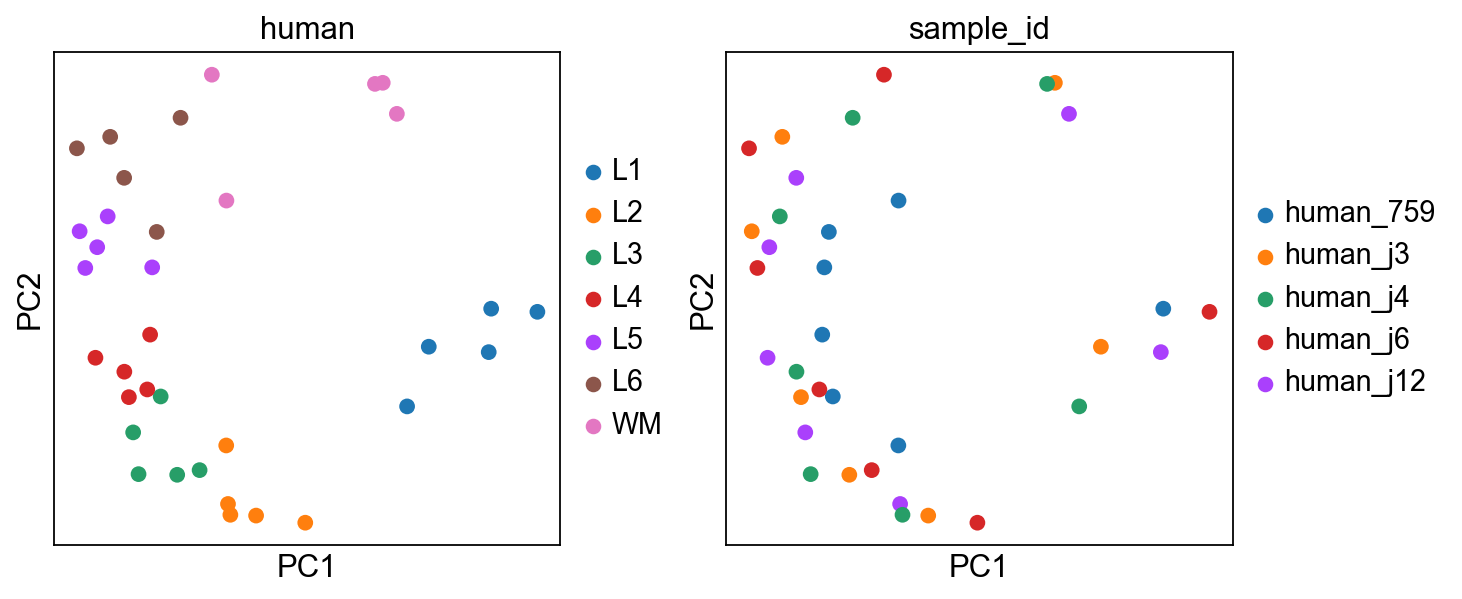

computing PCA
    with n_comps=30
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


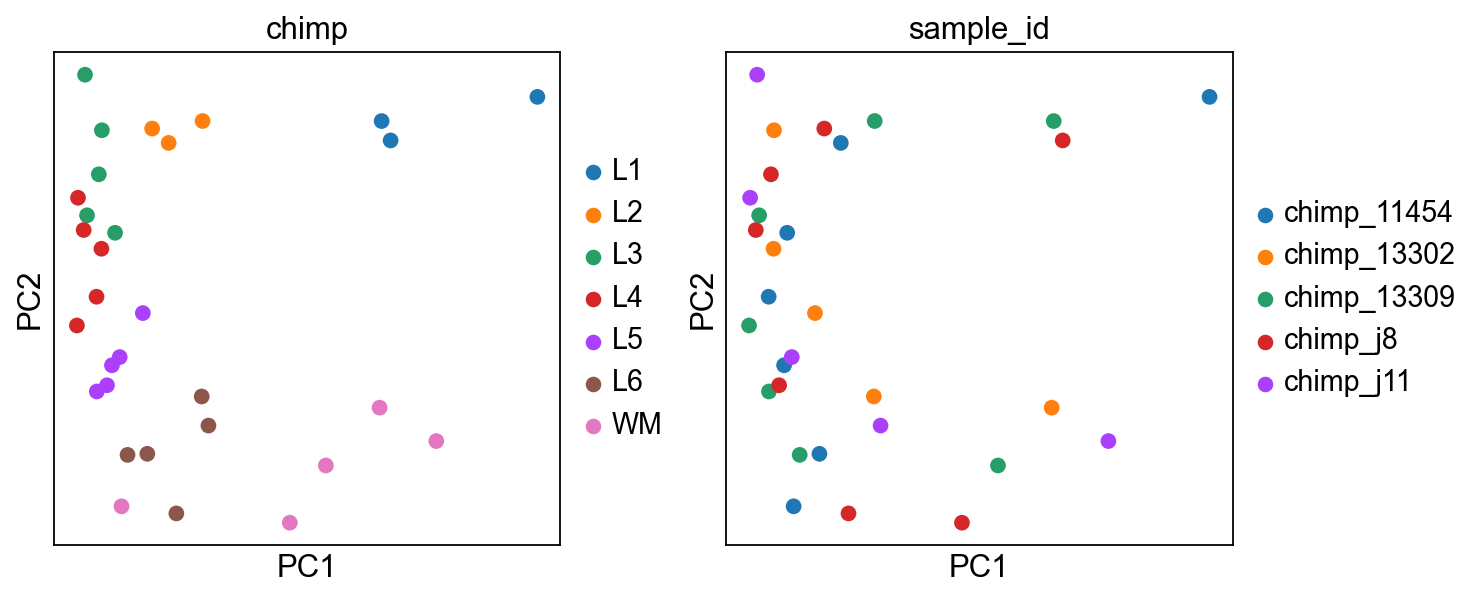

computing PCA
    with n_comps=27
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


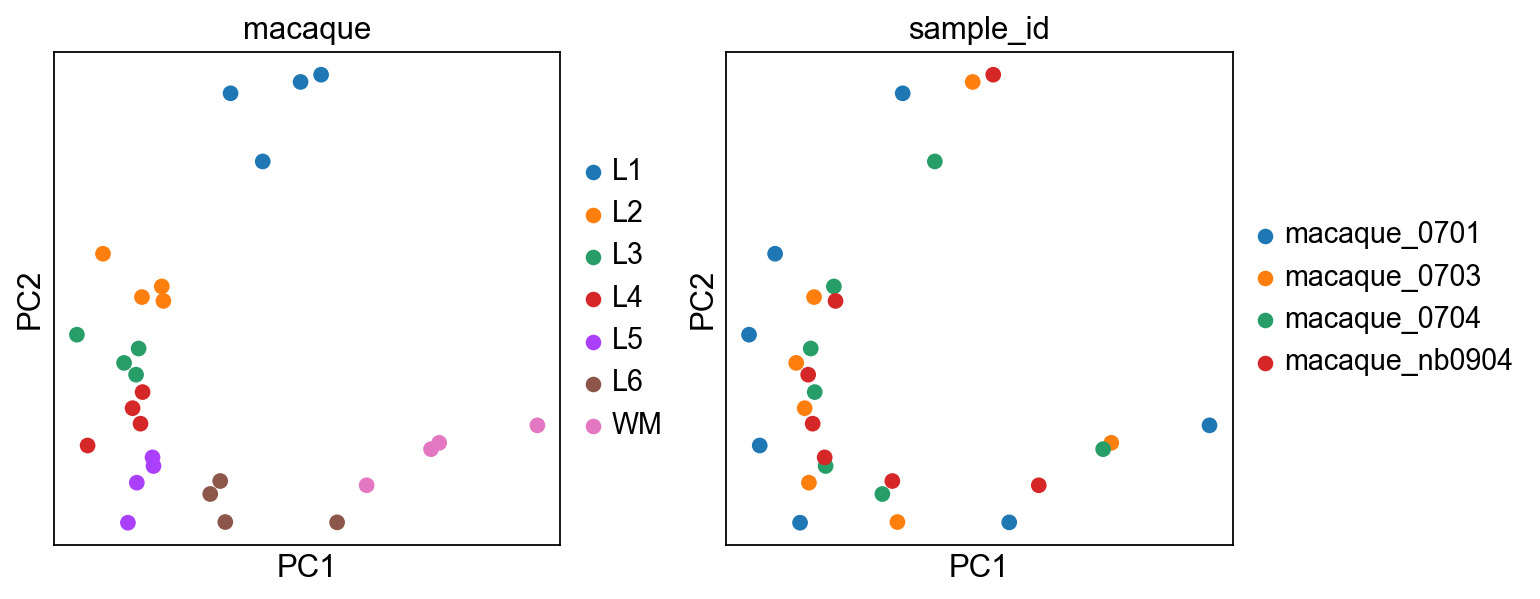

computing PCA
    with n_comps=50
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


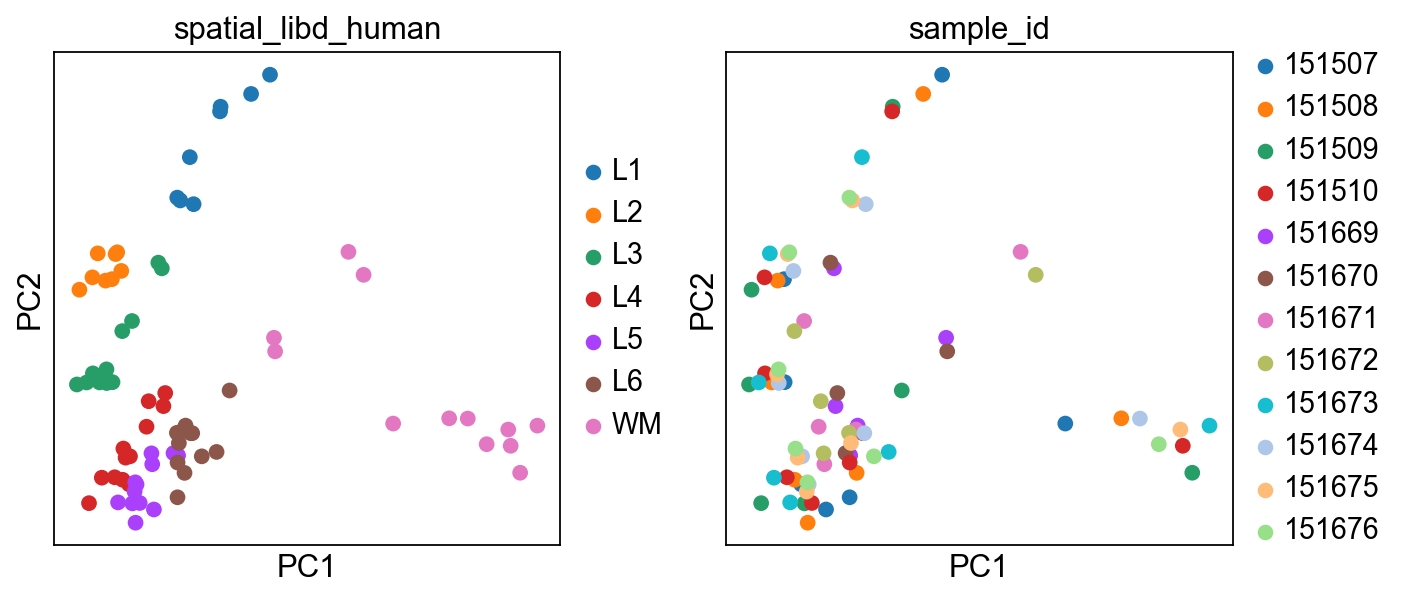

In [18]:
for cond in ['human', 'chimp', 'macaque', 'spatial_libd_human']:
    adata_cond = adata_pb_merged_norm[adata_pb_merged_norm.obs.condition == cond, :].copy()
    sc.pp.pca(adata_cond, return_info=False)
    sc.pl.pca(adata_cond, color=['layer', 'sample_id'], size=200, ncols=2, title=cond)

computing PCA
    with n_comps=50
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


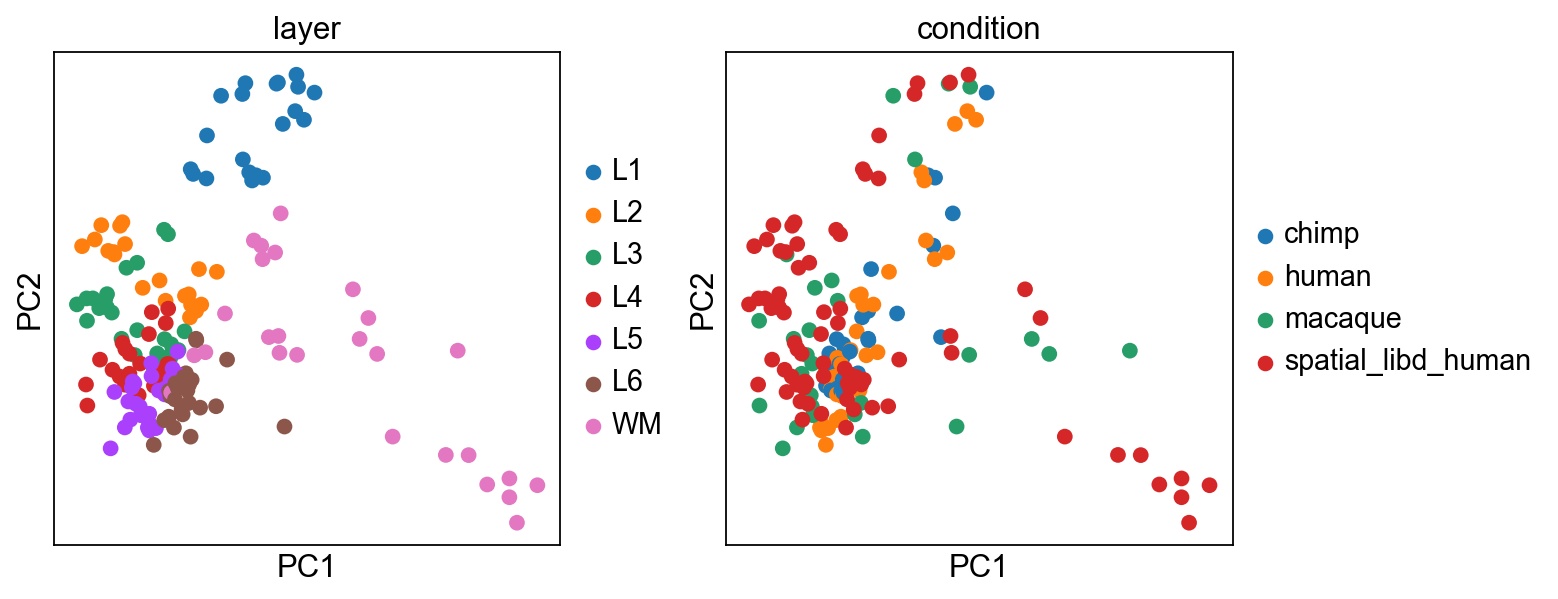

In [19]:
sc.pp.pca(adata_pb_merged_norm)
sc.pl.pca(adata_pb_merged_norm, color=['layer', 'condition'], size=200, ncols=2)

## Specie-specific genes

In [20]:
from statsmodels.stats.multitest import multipletests
res_dict = dict()
res_dict['human-chimp'] = pd.read_csv('results/edgeR_human_chimp.csv', index_col=0)
res_dict['human-macaque'] = pd.read_csv('results/edgeR_human_macaque.csv', index_col=0)
res_dict['chimp-macaque'] = pd.read_csv('results/edgeR_chimp_macaque.csv', index_col=0)

for key, df in res_dict.items():
    mult_test = multipletests(df['PValue'], method='fdr_bh')
    df['p_val_adj'] = mult_test[1]

res_dict['human-chimp'].head()

,logFC.spline_1.human,logFC.spline_2.human,logFC.spline_3.human,logCPM,F,PValue,p_val_adj
A1BG,0.244038,0.286535,0.252427,8.937955,1.353039,0.266747,0.847434
AACS,-0.388070,-0.241365,-0.039750,8.898749,1.925657,0.131096,0.624955
AADAT,-0.399771,-0.369816,-0.361727,8.822620,0.269978,0.846744,1.000000
AAGAB,0.086928,0.361438,0.044400,8.837510,0.579746,0.630315,1.000000
AAK1,0.231119,0.421302,0.032839,8.977608,0.409947,0.746269,1.000000


In [21]:
sign_genes = lambda df: df[df.p_val_adj < 0.05].index
sign_genes_dict = {key:sign_genes(df) for key, df in res_dict.items()}
sign_genes_dict

{'human-chimp': Index(['ACTN2', 'ADGRB2', 'ADGRG1', 'ADGRL1', 'ALCAM', 'AMZ2', 'ANK3', 'AP2S1',
        'APBA1', 'APBA2',
        ...
        'UQCRB', 'UQCRH', 'VAT1L', 'WDR37', 'WLS', 'ZBTB18', 'ZBTB46',
        'ZCCHC17', 'ZMYND8', 'ZNF706'],
       dtype='object', length=224),
 'human-macaque': Index(['AACS', 'AARS1', 'AATK', 'ABAT', 'ABCA2', 'ABCC10', 'ABCC5', 'ABCD3',
        'ABCD4', 'ABHD10',
        ...
        'ZNF483', 'ZNF536', 'ZNF579', 'ZNF706', 'ZNF770', 'ZNF791', 'ZNHIT3',
        'ZRANB2', 'ZYG11B', 'ZYX'],
       dtype='object', length=2141),
 'chimp-macaque': Index(['AARS1', 'AATK', 'ABAT', 'ABCD3', 'ABCD4', 'ABLIM3', 'ABTB1', 'ACAD9',
        'ACHE', 'ACOT7',
        ...
        'YPEL5', 'YWHAB', 'YWHAG', 'ZDHHC22', 'ZDHHC8', 'ZDHHC9', 'ZFAND5',
        'ZMPSTE24', 'ZNF536', 'ZNF655'],
       dtype='object', length=1057)}

Попробуем определить человеко-специфичные гены как $(HC\bigcap HM)\setminus CM$

In [22]:
hs_genes = sign_genes_dict['human-chimp'].intersection(sign_genes_dict['human-macaque']).difference(sign_genes_dict['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['ALCAM', 'AMZ2', 'ASAH1', 'ASAP2', 'ATP1A3', 'CALR', 'CAMLG', 'CD47',
        'CHST10', 'CLSTN1', 'COTL1', 'CX3CL1', 'DLGAP4', 'ECSIT', 'EEF1G',
        'EIF1B', 'EIF3L', 'ERC1', 'ETFB', 'FBXO9', 'GAD1', 'GDE1', 'GNAI1',
        'GPX4', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21', 'KIF21B', 'KLHL2', 'LDHB',
        'LHX2', 'LPL', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51', 'NDUFB10',
        'NDUFB7', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4', 'PDE1A', 'PES1',
        'PPA1', 'PPP1CC', 'PSMB7', 'PTPRK', 'RBIS', 'RGS2', 'SCN3B', 'SEPTIN6',
        'ST3GAL5', 'SULF2', 'SYNGAP1', 'TCEAL4', 'TMED3', 'TRIR', 'UBE2V1',
        'VAT1L', 'ZBTB18', 'ZBTB46', 'ZNF706'],
       dtype='object'),
 65)

In [23]:
background_genes = res_dict['human-chimp'].index.tolist()
len(background_genes)

7790

## Fit splines

In [24]:
df = pd.DataFrame(adata_pb_merged_norm.X, index=adata_pb_merged_norm.obs_names, columns=adata_pb_merged_norm.var_names)

In [25]:
common_hs_genes = df.columns.intersection(hs_genes)
common_hs_genes

Index(['ALCAM', 'AMZ2', 'ASAH1', 'ASAP2', 'ATP1A3', 'CALR', 'CAMLG', 'CD47',
       'CHST10', 'CLSTN1', 'COTL1', 'CX3CL1', 'DLGAP4', 'ECSIT', 'EEF1G',
       'EIF1B', 'EIF3L', 'ERC1', 'ETFB', 'FBXO9', 'GAD1', 'GDE1', 'GNAI1',
       'GPX4', 'ID2', 'IGFBP2', 'IGFBP6', 'IGSF21', 'KIF21B', 'KLHL2', 'LDHB',
       'LHX2', 'LPL', 'MACF1', 'MAP1LC3B', 'MAZ', 'MRPL51', 'NDUFB10',
       'NDUFB7', 'NRXN1', 'NRXN2', 'NUAK1', 'OLA1', 'PCP4', 'PDE1A', 'PES1',
       'PPA1', 'PPP1CC', 'PSMB7', 'PTPRK', 'RGS2', 'SCN3B', 'ST3GAL5', 'SULF2',
       'SYNGAP1', 'TCEAL4', 'TMED3', 'TRIR', 'UBE2V1', 'VAT1L', 'ZBTB18',
       'ZBTB46', 'ZNF706'],
      dtype='object')

In [26]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque', '151']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['151']
df = df.loc[sample_order['all']]
df_hs = df[common_hs_genes].copy()

In [27]:
df_annotation = df.copy()
df_annotation['layer'] = adata_pb_merged_norm.obs.layer
df_annotation['condition'] = adata_pb_merged_norm.obs.condition

In [28]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

A1BG      A1CF     A2ML1    A4GALT      AAAS      AACS  \
condition layer                                                               
chimp     L1    -0.000369 -0.000093  0.002973  0.000000  0.020916 -0.069561   
          L2    -0.025422 -0.000093 -0.000480  0.000000 -0.011436 -0.121073   
          L3     0.072973  0.000333 -0.004459 -0.000183 -0.012736 -0.023338   
          L4     0.048867 -0.000056 -0.001298 -0.000183  0.012735  0.065496   
          L5    -0.006497 -0.000056 -0.005684  0.000733 -0.021140  0.061146   

                    AADAC  AADACL3     AADAT     AAGAB  ...    ZSWIM9  \
condition layer                                         ...             
chimp     L1    -0.000285      0.0  0.003757  0.003966  ... -0.039039   
          L2    -0.000285      0.0 -0.001879  0.010229  ...  0.033697   
          L3    -0.000171      0.0  0.024841  0.001084  ... -0.003202   
          L4    -0.000171      0.0  0.007000  0.020186  ...  0.007338   
          L5    -0.000171      0.0 -0.006989 -0.012458  ...  0.001774   

                     ZUP1      ZW10    ZWILCH     ZWINT      ZXDC  ZYG11A  \
condition layer                                                             
chimp     L1    -0.102083 -0.010687  0.002430 -0.001953  0.022041     0.0   
          L2     0.026167 -0.026889  0.003307  0.022254 -0.010872     0.0   
          L3     0.004870 -0.004886  0.000622  0.005005 -0.004683     0.0   
          L4     0.003895  0.002275  0.002139  0.000360  0.002403     0.0   
          L5     0.008903  0.009834 -0.013653 -0.001168  0.000610     0.0   

                   ZYG11B       ZYX     ZZEF1  
condition layer                                
chimp     L1    -0.007310  0.005502 -0.037485  
          L2     0.005819 -0.003722  0.016516  
          L3     0.000044  0.004101 -0.006557  
          L4     0.001038  0.001486 -0.003278  
          L5    -0.001919 -0.000016 -0.002532  

[5 rows x 14611 columns]

In [29]:
df_cont = df_annotation.copy()
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)

In [30]:
df_cont.to_csv('results/mean_norm_expr_adults_mammals.csv')

In [31]:
from scipy.interpolate import UnivariateSpline

grid = np.linspace(1, 7, 400)
array = np.zeros((grid.size, len(common_hs_genes)))
df_list = []

for specie in conditions:
    for i, gene in enumerate(common_hs_genes):
        #fit spline
        subs_index = df_cont[df_cont.condition == specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=common_hs_genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline = pd.concat(df_list)

In [32]:
df_spline.to_csv('results/hs_norm_splines_adults_mammals.csv')